# Quantum Optimization

## Environment Setup

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pandas as pd
import collections
from collections import defaultdict
from itertools import combinations
import itertools
import math
import networkx as nx
import numpy as np
import json
import csv
import os
import datetime
from networkx.algorithms import community
import scipy.sparse as sp
import scipy.spatial
import warnings
import pickle
import requests

## Helper Functions - Community Detection

In [4]:
import sys
sys.path.insert(1, './src')
from utils import download_graphs, clean_graph_data
from graph_community import CommunityGraphFactory, load_node_labels, draw_graph_community
from qbsolv_community import QbsolvCommunity, CommunityDetectionSolver

# Create a output folder to store files
if not os.path.exists('output'):
    os.makedirs('output')
    
# get timenow for file naming 
timenow = str(datetime.datetime.now())[:19]

## Download Graph Data

In [5]:
# set a directory to store graph data
data_dir = "./data"

# download graph zip file and store the data under data_dir
#download_graphs(graph_url, data_dir)

# Get the City ID for your City - Denver's is city_id:ZGVudmVyY29sb3JhZG91bml0ZWQgc3RhdGVz
params = {
    "search": "Denver",
    "cursor": ""
}
def find_city_id(url):
    with requests.Session() as req:
        allin = []
        for _ in range(1, 400):
            r = req.get(url, params=params).json()
            allin.append(r)
            if 'cursor' in r:
                params['cursor'] = r['cursor']
            else:
                break

        goal = json.dumps(allin, indent=4)
        return goal
        
url = "https://api.helium.io/v1/cities"
json_data = find_city_id(url)
print(json_data)

[
    {
        "data": [
            {
                "short_state": "CO",
                "short_country": "US",
                "short_city": "Denver",
                "online_count": 1099,
                "offline_count": 466,
                "long_state": "Colorado",
                "long_country": "United States",
                "long_city": "Denver",
                "hotspot_count": 1565,
                "city_id": "ZGVudmVyY29sb3JhZG91bml0ZWQgc3RhdGVz"
            },
            {
                "short_state": "IA",
                "short_country": "US",
                "short_city": "Denver",
                "online_count": 2,
                "offline_count": 0,
                "long_state": "Iowa",
                "long_country": "United States",
                "long_city": "Denver",
                "hotspot_count": 2,
                "city_id": "ZGVudmVyaW93YXVuaXRlZCBzdGF0ZXM"
            },
            {
                "short_state": "NC",
                "short_count

In [7]:
# Use the City ID to get all hotspots in that city - for Denver, takes about 15 seconds

params = {
    "city_id": "ZGVudmVyY29sb3JhZG91bml0ZWQgc3RhdGVz",
    "cursor": ""
}
def download_data_for_city(url):
    with requests.Session() as req:
        allin = []
        for _ in range(1, 400):
            r = req.get(url, params=params).json()
            allin.append(r)
            if 'cursor' in r:
                params['cursor'] = r['cursor']
            else:
                break

        goal = json.dumps(allin, indent=4)
        return goal
        
url = "https://api.helium.io/v1/cities/ZGVudmVyY29sb3JhZG91bml0ZWQgc3RhdGVz/hotspots"
json_hotspots = download_data_for_city(url)
print(json_hotspots)

[
    {
        "data": [
            {
                "lng": -105.03144312349312,
                "lat": 39.72253445104351,
                "timestamp_added": "2022-04-09T03:43:47.000000Z",
                "status": {
                    "timestamp": null,
                    "online": "online",
                    "listen_addrs": null,
                    "height": null
                },
                "reward_scale": 0.2310028076171875,
                "payer": "14h2zf1gEr9NmvDb2U53qucLN2jLrKU1ECBoxGnSnQ6tiT6V2kM",
                "owner": "146Hnk53wnwKws8o2nbYo3WGMPz5CvSvtPh5ptc2XvcfSW5HqYv",
                "nonce": 1,
                "name": "spicy-inky-guppy",
                "mode": "full",
                "location_hex": "88268cd81bfffff",
                "location": "8c268cd81a00dff",
                "last_poc_challenge": 1305678,
                "last_change_block": 1305724,
                "geocode": {
                    "short_street": "Julian St",
                    

In [8]:
# store data
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print("Created ./graph_data directory in local machine to store graph data.")
    
# now we will open a file for writing
data_path = os.path.join(data_dir, 'data_file.csv')
data_file = open(data_path, 'w')
 
# create the csv writer object
csv_writer = csv.writer(data_file)
 
hotspot_data = json.loads(json_hotspots)[0]["data"]
# Counter variable used for writing
# headers to the CSV file
count = 0
 
for hotspot in hotspot_data:
    if count == 0:
 
        # Writing headers of CSV file
        header = hotspot.keys()
        csv_writer.writerow(header)
        count += 1
 
    # Writing data of CSV file
    csv_writer.writerow(hotspot.values())

data_file.close()

In [9]:
# import point data as xy coordinates of the form: points = [(0,0),(0,1),(2,2),(3,4),(4,3)] 

def merge(list1, list2):
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

# creating empty lists
lat = []
lng = []

with open(data_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    #iterating over each row and append values to empty list - have to upscale the lat/lng due to requirement
    # that data be represented in QUBO as ints and not floats (need discrete data, not continuous)
    for col in reader:
        lat.append(int(float(col['lat'])*1000))
        lng.append(int(float(col['lng'])*1000))

points = merge(lat, lng)
print(points)

# now we will open a file for writing
points_data_path = os.path.join(data_dir, 'graph_points.csv')
points_data_file = open(points_data_path, 'w')
 
# create the csv writer object
csv_writer = csv.DictWriter(points_data_file, ["Lat", "Lng"])
 
for i in range(len(lat)):
    new_row = {"Lat": str(lat[i]), "Lng": str(lng[i])}
    csv_writer.writerow(new_row)
    

points_data_file.close()

[(39722, -105031), (39784, -105012), (39817, -105030), (39734, -104978), (39752, -104998), (39752, -104999), (39757, -105002), (39659, -104855), (39666, -105025), (39750, -104992), (39750, -104992), (39757, -104896), (39759, -105007), (39775, -105027), (39766, -105022), (39739, -104980), (39751, -105039), (39700, -104869), (39728, -104939), (39657, -104901), (39751, -104976), (39782, -105042), (39768, -105021), (39776, -104948), (39743, -105026), (39776, -104830), (39739, -104969), (39845, -105001), (39625, -105094), (39784, -105020), (39694, -104963), (39738, -104971), (39779, -104747), (39785, -104824), (39757, -104954), (39714, -104909), (39716, -105025), (39773, -104821), (39746, -104991), (39707, -104971), (39683, -104987), (39761, -105007), (39773, -104949), (39682, -104964), (39836, -104996), (39695, -104890), (39693, -104967), (39746, -104963), (39699, -104975), (39720, -104979), (39738, -105029), (39729, -104938), (39771, -105049), (39720, -104981), (39743, -105040), (39793, -

In [10]:
# make a Delaunay triangulation of the point data
delTri = scipy.spatial.Delaunay(points)

# create a set for edges that are indexes of the points
edges = set()
# for each Delaunay triangle
for n in range(delTri.nsimplex):
    # for each edge of the triangle
    # sort the vertices
    # (sorting avoids duplicated edges being added to the set)
    # and add to the edges set
    edge = sorted([delTri.vertices[n,0], delTri.vertices[n,1]])
    edges.add((edge[0], edge[1]))
    edge = sorted([delTri.vertices[n,0], delTri.vertices[n,2]])
    edges.add((edge[0], edge[1]))
    edge = sorted([delTri.vertices[n,1], delTri.vertices[n,2]])
    edges.add((edge[0], edge[1]))

In [11]:
# make a graph based on the Delaunay triangulation edges 
graph = nx.Graph(list(edges))
print(graph.edges()) 

[(288, 597), (288, 3), (288, 412), (288, 608), (288, 435), (597, 455), (597, 741), (597, 518), (597, 608), (597, 260), (597, 412), (597, 852), (36, 360), (36, 400), (36, 965), (36, 691), (36, 560), (36, 859), (360, 75), (360, 720), (360, 418), (360, 400), (360, 73), (360, 972), (360, 859), (360, 810), (360, 359), (360, 50), (293, 614), (293, 38), (293, 326), (293, 137), (293, 10), (293, 81), (614, 766), (614, 326), (614, 137), (614, 613), (614, 521), (901, 940), (901, 453), (901, 520), (901, 193), (901, 257), (901, 185), (901, 242), (940, 635), (940, 962), (940, 520), (940, 257), (217, 820), (217, 750), (217, 985), (217, 833), (820, 265), (820, 94), (820, 750), (820, 833), (820, 282), (215, 769), (215, 746), (215, 828), (215, 728), (215, 324), (215, 886), (215, 999), (215, 213), (769, 746), (769, 599), (769, 903), (769, 516), (769, 67), (769, 828), (329, 850), (329, 753), (329, 21), (329, 644), (329, 590), (329, 448), (850, 317), (850, 13), (850, 62), (850, 644), (850, 753), (914, 981)

In [12]:
# plot graph
#pointIDXY = dict(zip(range(len(points)), points))
#nx.draw(graph, pointIDXY)
#plt.show() 

## Prepare Graph for Community Detection

In [13]:
# call CommunityGraphFactory for graph data preparation
cgf = CommunityGraphFactory(seed=1)

# Required format:  {graph_name: [data_path, delimiter]}
graph_file_dict = {"HNTDenver": [points_data_path, ","]}           

## Load Graph

Name: 
Type: Graph
Number of nodes: 473
Number of edges: 923
Average degree:   3.9027


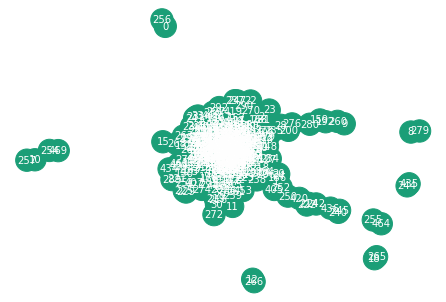

In [14]:
# load a graph from local files defined in 'graph_file_dict'
graph_name = "HNTDenver"
graph_city = cgf.load_graph(graph_name, graph_file_dict)
draw_graph_community(graph_city, [list(range(graph_city.number_of_nodes()))], color_map = 'Dark2')
plt.show()

# QBSolv for Community Detection

## Set Community Parameters and Hyperparameters

In [15]:
# Graph Parameters
## use a real-world graph that was created in the previous section
k = 5
graph_name = 'HNTDenver'
nx_G = graph_city

# QBSolv parameters
solver_limit = 40 # the maximum number of variables (n) for sub-QUBOs
num_repeats = 1 # the maximum iterations to repeat QBSolv solver execution to discover a new best solution
num_reads = 50 # how many times the annealing is performed
seed = 1 # random seed
alpha = 5 # the penalty coefficient to enforce assigning only one community to each node

# for QBSolv hybrid only
device_arn = 'arn:aws:braket:::device/qpu/d-wave/Advantage_system4' # D-Wave QPU Device ARN
my_prefix = f"{graph_name}_k{k}_sl{solver_limit}_nr{num_repeats}_s{num_reads}_seed{seed}" #the folder name in the S3 braket bucket
my_bucket = f"amazon-braket-df26ca2b1d29" # rename 'amazon-braket-your-bucket-name-here' with the name of your amazon S3 Braket bucket
s3_folder = (my_bucket, my_prefix)

print(f"S3 path for saving QBSolv results: {my_bucket}/{my_prefix}")


S3 path for saving QBSolv results: amazon-braket-df26ca2b1d29/HNTDenver_k5_sl40_nr1_s50_seed1


## Initialize QbsolvCommunity Class

In [16]:
qbsolv_comm = QbsolvCommunity(nx_G, solver_limit, num_repeats, num_reads, seed, alpha)

## Use QBSolv Classical Solver

In [17]:
# for Denver, takes about 1 minute at k = 5, 12 seconds for k = 2
comm_classical, _ = qbsolv_comm.solve_classical(k)
print(f"The best solution's modularity value is: {comm_classical['modularity']}")

The size of the QUBO matrix in dictionary format for 5-community is 1128105
Mode: Classical, time spent is 18.05 seconds for 1 repetitions
    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 2364    energy num_oc.
0   1  0  1  0  1  1  1  0  1  1  0  0  1  1  0  1 ...    0 -5.466116       1
1   0  1  1  0  0  1  0  0  1  1  1  1  0  0  0  0 ...    1 -5.450994       1
2   0  0  1  0  0  0  1  0  0  1  0  0  0  0  1  1 ...    0 -5.449456       1
3   1  1  1  0  0  0  0  0  0  1  0  0  0  1  1  1 ...    1 -5.448473       1
4   0  1  1  0  0  1  0  0  1  0  0  0  0  0  0  1 ...    1 -5.446726       1
5   0  0  0  0  0  0  0  0  0  1  0  1  0  1  0  1 ...    0  -5.44666       1
6   0  1  1  0  0  0  0  0  1  1  0  0  1  0  0  1 ...    1 -5.446346       1
7   1  0  0  1  0  1  0  0  0  0  1  0  1  1  0  1 ...    0 -5.445524       1
8   0  1  0  0  1  0  0  0  0  0  1  1  0  1  0  1 ...    1 -5.443634       1
9   0  1  1  0  0  0  0  0  0  0  1  0  1  1  1  1 ...    0 -5.442937       1
10 

In [93]:
print(comm_classical)

{'modularity': 0.46611572091086173, 'num_comm': 5, 'comm': [{0, 2, 4, 5, 6, 8, 9, 12, 13, 15, 16, 18, 21, 23, 25, 28, 30, 68, 96, 97, 109, 110, 112, 135, 142, 143, 155, 159, 168, 176, 177, 179, 180, 181, 182, 185, 187, 190, 192, 193, 194, 198, 200, 205, 208, 209, 212, 214, 222, 228, 231, 235, 240, 242, 245, 250, 251, 252, 254, 256, 258, 260, 264, 265, 266, 268, 272, 274, 276, 278, 279, 280, 281, 284, 288, 289, 291, 295, 298, 307, 309, 317, 321, 324, 325, 334, 340, 341, 358, 382, 385, 389, 405, 420, 422, 430, 436, 451, 452, 453, 455, 456, 458, 463, 469}, {1, 7, 10, 11, 19, 26, 27, 29, 33, 38, 41, 42, 50, 60, 62, 64, 65, 71, 75, 81, 82, 90, 93, 114, 118, 119, 120, 121, 122, 127, 130, 131, 139, 149, 157, 161, 163, 166, 171, 172, 174, 178, 184, 189, 191, 195, 197, 201, 202, 211, 218, 223, 225, 229, 232, 233, 238, 239, 241, 243, 248, 253, 255, 257, 259, 261, 263, 269, 273, 290, 296, 304, 306, 308, 310, 316, 320, 335, 336, 351, 359, 361, 363, 381, 384, 392, 400, 402, 403, 406, 407, 408, 410,

In [18]:
# We save the QBSolv response to a local pickle file
response_file = f"{timenow}_DwaveQBSolv_Classical_response_{my_prefix}.p"
pickle.dump(comm_classical, open('./output/'+response_file, "wb" ))

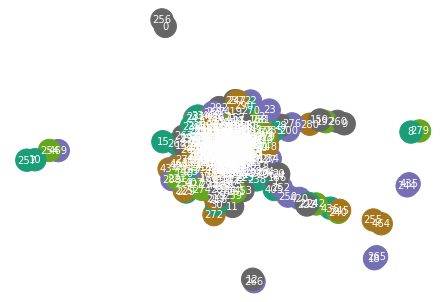

Saved figure to ./output: 2022-04-10 13:01:33_HNTDenver_DwaveQBSolv_classical_K5_Modu_0.4661.png


In [19]:
# We plot a graph colored with communities and save it as an image
draw_graph_community(nx_G, comm_classical['comm'], color_map = 'Dark2')
savefig_name = f"{timenow}_{graph_name}_DwaveQBSolv_classical_K{k}_Modu_{round(comm_classical['modularity'], 4)}.png"
plt.savefig(os.path.join("./output", savefig_name), dpi=150)
plt.show()
print(f"Saved figure to ./output: {savefig_name}")


## Use QBSolv Hybrid Solver

In [20]:
comm_hybrid, _ = qbsolv_comm.solve_hybrid(k, s3_folder, device_arn)
print(f"Modularity value is: {comm_hybrid['modularity']}")

The size of the QUBO matrix in dictionary format for 5-community is 1128105
Continue to execute QBSolv Hybrid job: Y or N?Y
Mode: Hybrid, time spent is 1644.28 seconds for 1 repeats
    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 2364    energy num_oc.
0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 ...    0 -5.446918       1
1   0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0 ...    0  -5.44587       1
2   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1 ...    1 -5.439315       1
3   1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  1 ...    0  -5.43886       1
4   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 ...    0 -5.437758       1
5   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...    0 -5.436857       1
6   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 ...    0  -5.43579       1
7   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...    1 -5.435432       1
8   0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0 ...    0 -5.435144       1
9   0  0  1  0  0  0  0  0  0  0  0  0

In [21]:
print(comm_hybrid)

{'modularity': 0.44691752481705127, 'num_comm': 5, 'comm': [{0, 2, 5, 9, 12, 16, 17, 21, 22, 23, 33, 41, 42, 54, 58, 60, 61, 70, 90, 93, 114, 120, 121, 126, 127, 139, 148, 157, 159, 161, 163, 164, 166, 168, 174, 187, 192, 194, 200, 201, 203, 208, 212, 214, 215, 219, 223, 231, 234, 235, 236, 238, 242, 245, 247, 248, 250, 252, 254, 256, 260, 261, 263, 264, 266, 270, 271, 273, 274, 280, 281, 285, 289, 290, 295, 306, 309, 313, 315, 318, 329, 336, 351, 359, 363, 369, 389, 400, 405, 408, 413, 416, 417, 420, 424, 429, 430, 436, 446, 447, 448, 449, 451, 454, 460, 464, 466, 468, 469, 470}, {1, 7, 8, 10, 13, 14, 25, 26, 27, 45, 56, 71, 80, 85, 86, 87, 91, 92, 96, 101, 102, 106, 107, 111, 112, 129, 130, 135, 140, 142, 143, 147, 150, 153, 158, 170, 171, 173, 178, 179, 184, 190, 195, 216, 221, 222, 225, 237, 240, 241, 243, 251, 257, 262, 279, 283, 291, 292, 296, 298, 310, 322, 327, 334, 338, 339, 340, 341, 346, 347, 349, 355, 358, 360, 361, 368, 376, 377, 378, 380, 386, 390, 391, 398, 419, 422, 423

In [22]:
# We save the QBSolv response to a local pickle file
response_file = f"{timenow}_DwaveQBSolv_Hybrid_response_{my_prefix}.p"
pickle.dump(comm_hybrid, open('./output/'+response_file, "wb" ))

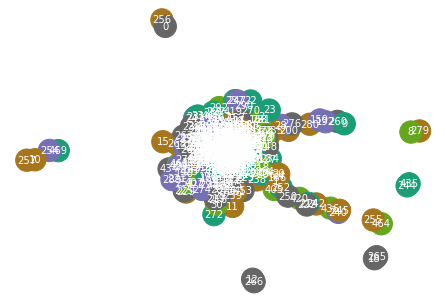

Saved figure to ./output: 2022-04-10 13:01:33_HNTDenver_DwaveQBSolv_hybrid_5_comm_modu_0.4469.png


In [23]:
# We plot a graph colored with communities and save it as an image
draw_graph_community(nx_G, comm_hybrid['comm'], color_map = 'Dark2')
savefig_name = f"{timenow}_{graph_name}_DwaveQBSolv_hybrid_{k}_comm_modu_{round(comm_hybrid['modularity'], 4)}.png"
plt.savefig(os.path.join("./output", savefig_name), dpi=150)
plt.show()
print(f"Saved figure to ./output: {savefig_name}")

